# Focus on the Property Tax Appeals



* **Appeals Process**: Property owners can appeal their assessments, which may lead to revised assessments<br>
* **Industry Impact**: Inaccuracies in initial assessments have created a multimillion-dollar industry around tax appeals<br>
* **Unfairness Concerns**: The system may introduce opportunities for unfairness, influenced by factors such as race or median income<br>
* **Monetary Rewards**: Factors affecting the monetary rewards of appealing include the amount gained from a successful appeal<br><br>
These points align with the issues of transparency and fairness in the property tax system<br>

# Executive Summary

Factors that lead a property owner to appeal. Parts played by factors like race or median income<br><br>
Based on the surveys, voters believe that the property tax is the most unfair worst tax. Therefore the property owners was introduced to use appealling to reduced the assesed value. So here we use a bigger, enriched dataset in this project, this dataset consisting of 19036 properties that have sold in the three regions of Cook County (Northwest Suburban Cook County, Chicago, Southwest Suburban Cook County) , among which 9018 properties appealled (47.4%), and the winning case is 5587, which mean the wining rate is 62%, overall CCAO and BOR granted 29% of those properties some reduction in their assesed values.
This dataframe contains 26 columns,and all 26 columns have missing value. 
remove Outliers( for min value is 50K, min squre foot is 300)
We created new column variable Appeal_1_0 to represent that property has appealled or not, we also add column Log_Value and Log_medhinc

Based our analysis Some of these correlations may be driven by the fact that taxpayers self-select as to whether they appeal their taxes or not: 
First pass assessed value, property actual sale value (or Log_value) and squarefoot, median household income of the property owner, percentage of eligible adults in the property's census tract with a 4 year college degree and average school score are all positive correlated with the property owner would appeal or not, it shows high income, higher level of education and rich home owner has bigger posibility to make appeal, also regard to race,  white compare with other race has bigger posibility to make appeal.
Also, many larger condominiums buildings can hire attorneys tofile appeals for all of the units in the building, taking advantage of the returns to scale in this type of appeal.Neighbours may share the information with each other, result in some neighborhoods having a very high rate of appeal, simply because of the compounding effect. Laywer may have target customer to encourage them file the appeal, this all realted to why high income, high educate and white people lead the appeal happen.

Following factors affect the monetary rewards of appealing: tri_Chicago,value(property actual sale value), squarefoot, poverty and Non_Condo

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.api as smapi
import seaborn as sns
from scipy.stats import f
from scipy.stats import pearsonr

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 100

In [3]:
df = pd.read_csv("../data/project2data.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../assignment_data/project2data.csv'

In [ ]:
# To call from anywhere, for debugging purpose
def reload_model():
    df = None
    df = pd.read_csv("../data/project2data.csv")
    

# Functions declaration

In [ ]:
def missing_values_table(df):
    '''missing_values_table: Display % of missing values per column'''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[(
        mis_val_table_ren_columns.iloc[:,1] != 0) |
        (mis_val_table_ren_columns.iloc[:,1] == 0)].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [ ]:
def dump(obj):
  for attr in dir(obj):
    print("obj.%s = %r" % (attr, getattr(obj, attr)))

In [ ]:
def race_onehotencoder(dfin):
    so = []
    for i in range(len(dfin)):
        if (dfin["white"].loc[i]>dfin["black"].loc[i])&(dfin["white"].loc[i]>dfin["hispanic"].loc[i])&(dfin["white"].loc[i]>dfin["asian"].loc[i]): 
             so.append("w")
        elif (dfin["black"].loc[i]>dfin["white"].loc[i])&(dfin["black"].loc[i]>dfin["hispanic"].loc[i])&(dfin["black"].loc[i]>dfin["asian"].loc[i]):
            so.append("b")
        elif (dfin["hispanic"].loc[i]>dfin["black"].loc[i])&(dfin["hispanic"].loc[i]>dfin["white"].loc[i])&(dfin["hispanic"].loc[i]>dfin["asian"].loc[i]):
            so.append("h")
        elif (dfin["asian"].loc[i]>dfin["black"].loc[i])&(dfin["asian"].loc[i]>dfin["hispanic"].loc[i])&(dfin["asian"].loc[i]>dfin["white"].loc[i]):
            so.append("a")
        else: 
            so.append("u")
    dfin["race"] = so
    dfin = pd.get_dummies(dfin, columns=["race"])
    return dfin

In [ ]:
# Let's detect the outliers using the IQR method (not run)

def cutoffs (serie):
    '''cutoffs: returns cutoff values at +/- 1.5*iqr'''
    
    # Calculate IQR
    q1, q2, q3 = serie.quantile([.25,.5,.75])
    iqr = q3-q1
    
    # Calculate upper and lower cut-offs
    lowcut = q1 - (1.5*iqr)
    highcut = q3 + (1.5*iqr)
    
    return lowcut, highcut

def filterwithcutoffs (dfin, column, min_val, keep_high=True):
    '''filterwithcutoffs: applies cutoff values at +/- 1.5*iqr'''
    dfout = None
    lowcutoff, highcutoff = cutoffs (dfin[column])
    if lowcutoff < min_val:
        lowcutoff = min_val
    if keep_high == True:
        df_out = dfin.loc[(dfin[column]>=lowcutoff)]
    else:
        df_out = dfin.loc[(dfin[column]>=lowcutoff) & (dfin[column]< highcutoff)]
    return df_out, lowcutoff, highcutoff

# End Functions declaration

In [ ]:
df

,pin14,tri,pdir,pstreet,pcity,tcity,condo,av1,value,taxes,homeowner,white,black,hispanic,asian,medhinc,poverty,college,squarefoot,beds,walkscore,walkfac,elem_score,high_school_score,avg_school_score,appeal
0,2.033200e+13,Chicago,S,LASALLE,CHICAGO,CHICAGO,Non-condo,11558.0,108000,1585.20000,1,0.009383,0.967010,0.012107,0.006961,30065.0,0.408146,0.149720,1223.0,3.0,73,Very Walkable,1,6,4,0.0
1,2.414410e+13,Chicago,S,SAWYER,CHICAGO,CHICAGO,Non-condo,19357.0,215000,3032.43990,1,0.958201,0.011670,0.064927,0.015701,87268.0,0.004164,0.223537,1320.0,3.0,55,Somewhat Walkable,10,8,9,0.0
2,1.408420e+13,Chicago,W,AINSLIE,CHICAGO,CHICAGO,Non-condo,76189.0,1364225,11644.69000,0,0.507349,0.214669,0.096806,0.244488,32930.0,0.263047,0.344634,4800.0,12.0,82,Very Walkable,5,2,4,4199.0
3,1.419130e+13,Chicago,N,OAKLEY,CHICAGO,CHICAGO,Non-condo,61525.0,1091500,3215.55000,0,0.884098,0.015355,0.087505,0.063736,92589.0,0.011499,0.517047,2620.0,4.0,76,Very Walkable,8,10,9,39109.0
4,1.129100e+13,Chicago,W,JUNEWAY,CHICAGO,CHICAGO,Non-condo,44434.0,380000,7200.37990,0,0.372888,0.502060,0.126906,0.072930,31063.0,0.323849,0.182889,1976.0,4.0,66,Somewhat Walkable,2,1,2,0.0
5,1.407210e+13,Chicago,W,SUMMERDALE,CHICAGO,CHICAGO,Non-condo,42633.0,379000,3999.46000,1,0.700627,0.046424,0.267001,0.210289,55300.0,0.115624,0.324944,1111.0,3.0,84,Very Walkable,7,5,6,0.0
6,1.722310e+13,Chicago,E,18TH,CHICAGO,CHICAGO,Non-condo,60341.0,700000,10827.98000,0,0.544368,0.263281,0.060651,0.163012,71563.0,0.121878,0.542263,2400.0,4.0,91,Walker's Paradise,4,4,4,0.0
7,1.433410e+13,Chicago,W,MENOMONEE,CHICAGO,CHICAGO,Non-condo,83075.0,905000,8770.46000,1,0.884189,0.048890,0.040915,0.048544,85528.0,0.079787,0.696402,1438.0,4.0,94,Walker's Paradise,7,9,8,9793.0
8,1.405320e+13,Chicago,N,RIDGE,CHICAGO,CHICAGO,Non-condo,84301.0,656250,10377.20000,0,0.685848,0.083346,0.254261,0.178264,62623.0,0.142172,0.462252,4950.0,12.0,93,Walker's Paradise,5,7,6,27671.0
9,1.313300e+13,Chicago,N,TROY,CHICAGO,CHICAGO,Non-condo,39731.0,355000,6576.87990,0,0.628940,0.039828,0.495415,0.264470,51393.0,0.137874,0.278220,3657.0,9.0,89,Very Walkable,4,2,3,3080.0


In [4]:
df["condo"].unique()

NameError: name 'df' is not defined

In [5]:
df.describe()
df.columns
df.count()

NameError: name 'df' is not defined

In [12]:
missing_values_table(df)

Your selected dataframe has 26 columns.
There are 26 columns that have missing values.


,Missing Values,% of Total Values
appeal,10018,52.6
pdir,5527,29.0
beds,5121,26.9
squarefoot,5121,26.9
white,122,0.6
college,122,0.6
poverty,122,0.6
medhinc,122,0.6
asian,122,0.6
black,122,0.6


## Factors that lead a property owner to appeal? To what extent do factors like race or median income play a part?

In [ ]:
# Dependent variable is the variable appeal that we need to transform into a categorical variable
# Independent variables are race - median income + ???

In [13]:
# Categorical variable Appeal_1_0 will carry the information that an appeal process happened even if it lead to a denial
df["Appeal_0_1"] = np.where(df["appeal"] >= 0, 1.0, 0.0)

In [14]:
df["Log_Value"] = np.log(df["value"])
df["Log_medhinc"] = np.log(df["medhinc"])

In [15]:
df["condo"].unique()

array(['Non-condo', 'Condominium'], dtype=object)

In [16]:
# Fixing the outliers for the highest values will remove many condominium entries
print(len(df))
df,lowcutoff, highcutoff = filterwithcutoffs (df, "value", min_val = 50000, keep_high=True)
print(lowcutoff, highcutoff)
print(len(df))

19036
50000 770000.0
18826


In [17]:
df["condo"].unique()

array(['Non-condo', 'Condominium'], dtype=object)

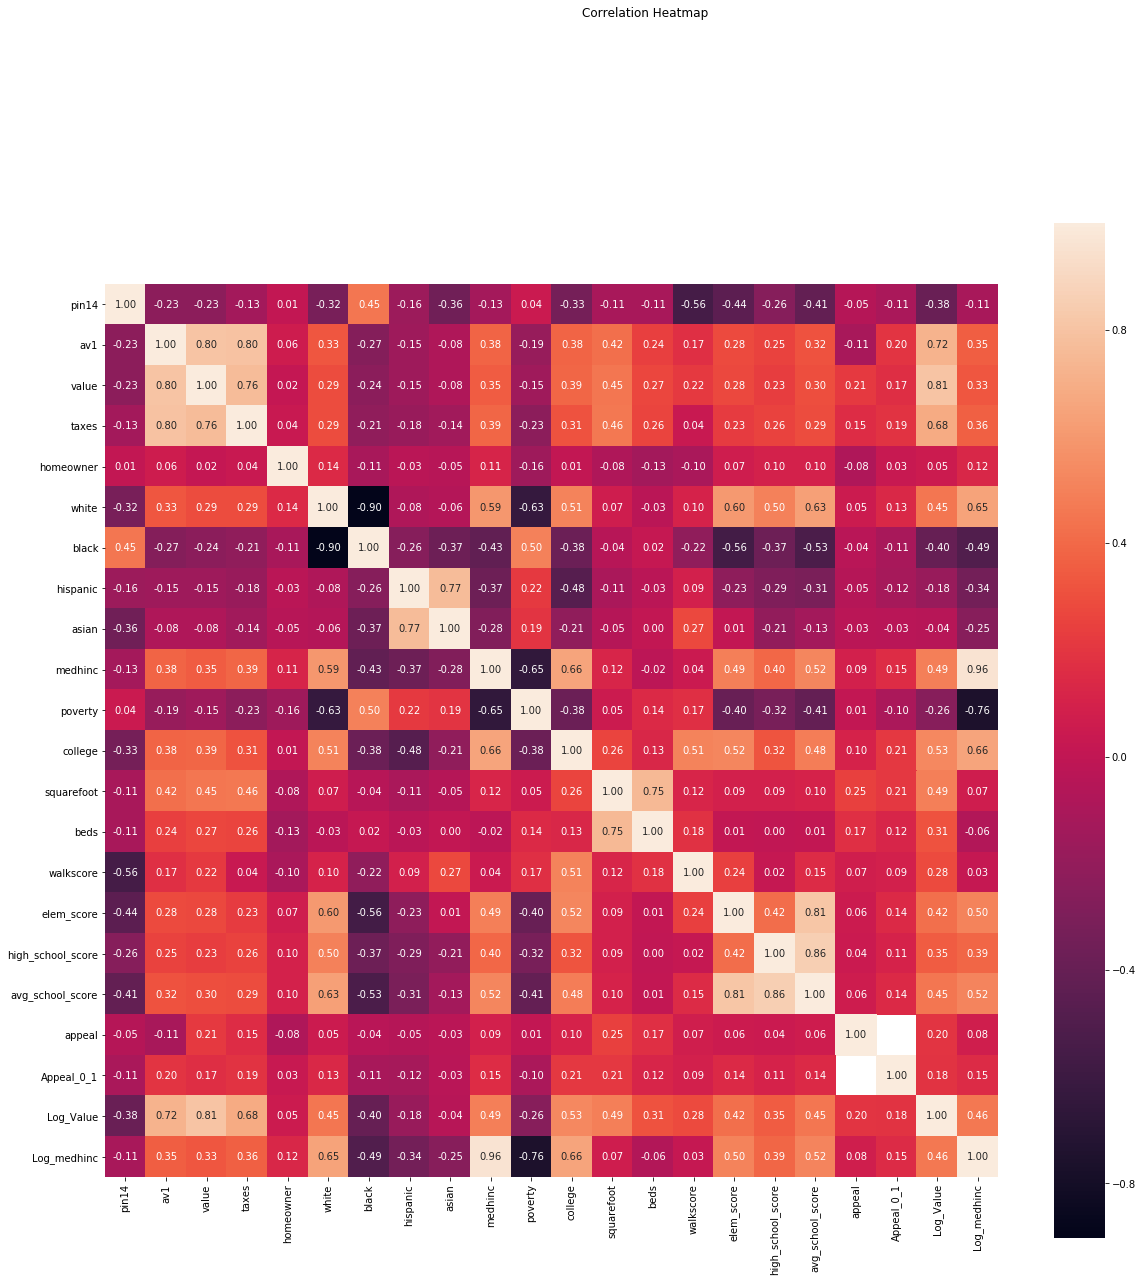

In [18]:
import matplotlib.pyplot as plt
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(corrmat,22), annot=True, ax=ax, square=True, fmt='.2f')
fig.subplots_adjust(top=0.83)
t=fig.suptitle("Correlation Heatmap", fontsize=12)

In [19]:
# Fixing the outliers for the squarefoot
print(len(df))
df,lowcutoff, highcutoff = filterwithcutoffs (df, "squarefoot", min_val = 300, keep_high=True)
print(lowcutoff, highcutoff)
print(len(df))

18826
300 4021.375
13800


In [20]:
df["condo"].unique()

array(['Non-condo'], dtype=object)

In [21]:
df = pd.get_dummies(df, columns=["condo"])
df.rename(columns={"condo_Non-condo":"Non_condo"}, inplace=True)

In [22]:
df[["squarefoot", "value","appeal"]].describe()

,squarefoot,value,appeal
count,13800.000000,1.380000e+04,6367.000000
mean,1913.742174,3.587792e+05,5484.628553
std,1168.083706,3.451783e+05,15594.464114
min,391.000000,5.000000e+04,0.000000
25%,1152.000000,1.700000e+05,0.000000
50%,1572.000000,2.600000e+05,1173.000000
75%,2300.000000,4.250000e+05,4543.500000
max,27270.000000,6.334000e+06,419346.000000


In [23]:
df["Sum_Race"] = df["white"] + df["black"] + df["hispanic"] + df["asian"]
df[["Sum_Race", "white", "black", "hispanic", "asian"]]

,Sum_Race,white,black,hispanic,asian
0,0.995460,0.009383,0.967010,0.012107,0.006961
1,1.050499,0.958201,0.011670,0.064927,0.015701
2,1.063313,0.507349,0.214669,0.096806,0.244488
3,1.050694,0.884098,0.015355,0.087505,0.063736
4,1.074784,0.372888,0.502060,0.126906,0.072930
5,1.224341,0.700627,0.046424,0.267001,0.210289
6,1.031312,0.544368,0.263281,0.060651,0.163012
7,1.022538,0.884189,0.048890,0.040915,0.048544
8,1.201720,0.685848,0.083346,0.254261,0.178264
9,1.428653,0.628940,0.039828,0.495415,0.264470


In [24]:
df["Sum_Race"].describe()

count    13784.000000
mean         1.183421
std          0.225484
min          0.980952
25%          1.034543
50%          1.083118
75%          1.238058
max          1.942879
Name: Sum_Race, dtype: float64

In [25]:
# Cleaning few missing records for races - 122 rows deleted
df.dropna(axis = 0, subset = ["white", "black", "hispanic", "asian"], inplace = True)
df.reset_index(drop=True, inplace=True)

In [26]:
df = race_onehotencoder (df)

In [27]:
df.columns

Index(['pin14', 'tri', 'pdir', 'pstreet', 'pcity', 'tcity', 'av1', 'value',
       'taxes', 'homeowner', 'white', 'black', 'hispanic', 'asian', 'medhinc',
       'poverty', 'college', 'squarefoot', 'beds', 'walkscore', 'walkfac',
       'elem_score', 'high_school_score', 'avg_school_score', 'appeal',
       'Appeal_0_1', 'Log_Value', 'Log_medhinc', 'Non_condo', 'Sum_Race',
       'race_a', 'race_b', 'race_h', 'race_w'],
      dtype='object')

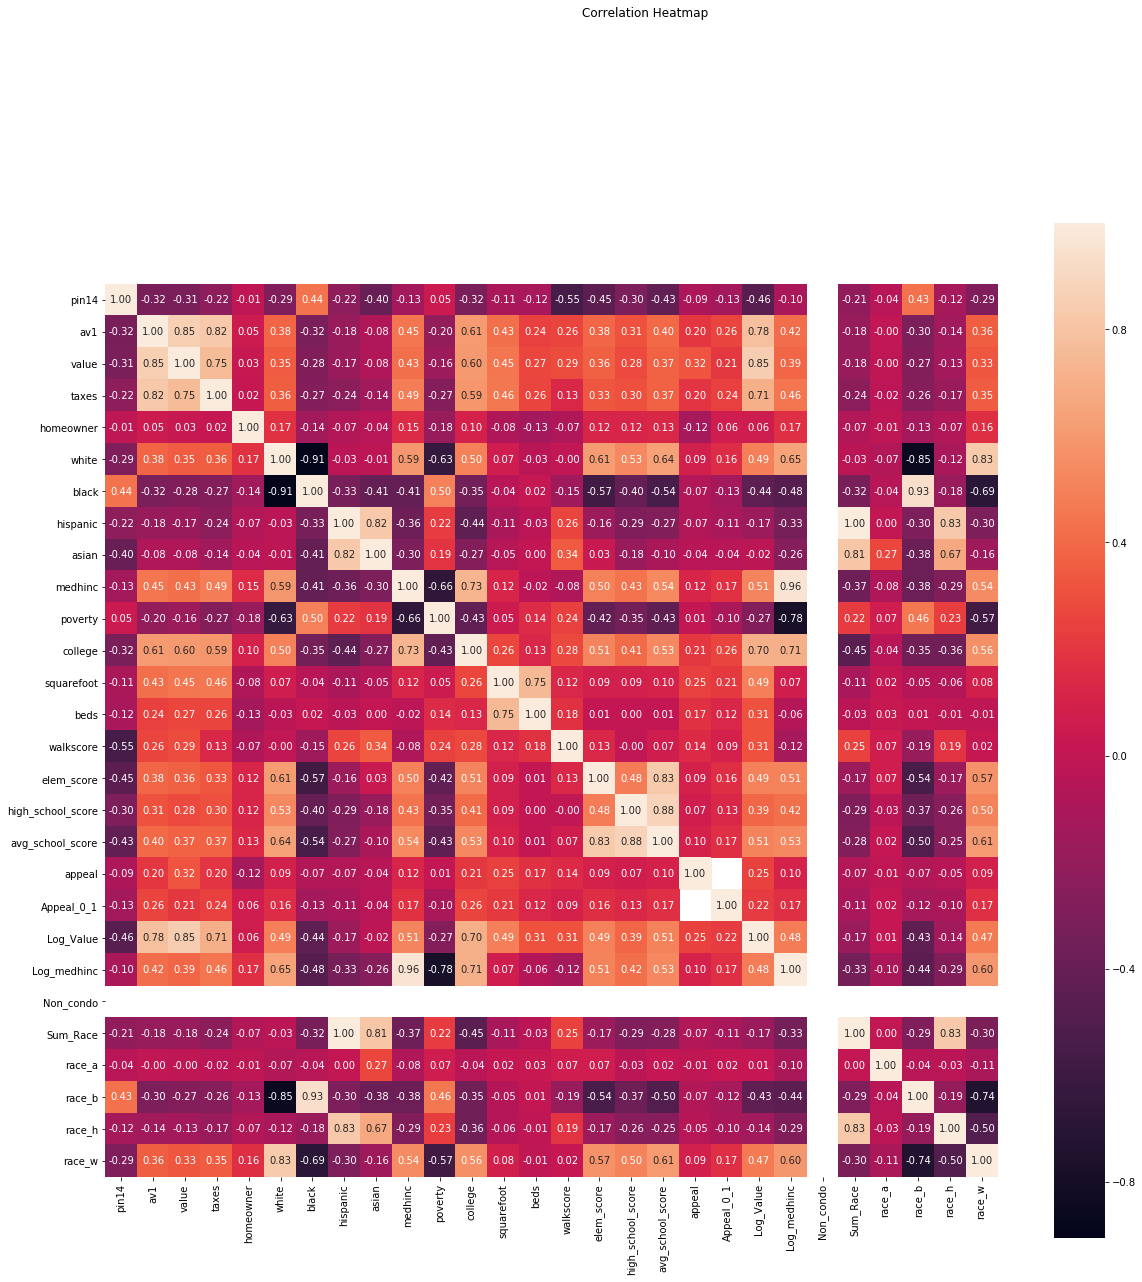

In [28]:
import matplotlib.pyplot as plt
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(corrmat,22), annot=True, ax=ax, square=True, fmt='.2f')
fig.subplots_adjust(top=0.83)
t=fig.suptitle("Correlation Heatmap", fontsize=12)

Pearson correlation coefficients ranges between 1 and -1, where 1 means the two features are maximally positively correlated, 1 means there is no correlation, and -1 means the two features are maximally negatively correlated. from the Correlation Heatmap graph can see Appeal_0_1 is correlated with following valables:  college, av1>taxes>Log_Value>squarefoot>medhinc>avg_school_score>race_w, and even the race_a is positive correlated with Appeal_0_1 but it's too small can be dropped and the other two races are negative correlated


In [29]:
# Choosing a multivariate model
model0 = sm.ols("Appeal_0_1 ~ college + av1+ taxes + Log_Value + squarefoot", data = df)
result0 = model0.fit()
model1 = sm.ols("Appeal_0_1 ~ college + av1+ taxes + Log_Value + squarefoot + medhinc", data = df)
result1 = model1.fit()
model2 = sm.ols("Appeal_0_1 ~ college + av1+ taxes + Log_Value + squarefoot + medhinc + avg_school_score ", data = df)
result2 = model2.fit()
model3 = sm.ols("Appeal_0_1 ~ college + av1+ taxes + Log_Value + squarefoot + medhinc + avg_school_score + race_w", data = df)
result3 = model3.fit()
model4 = sm.ols("Appeal_0_1 ~ college + av1+ taxes + Log_Value + squarefoot + medhinc + avg_school_score + race_w + race_a", data = df)
result4 = model4.fit()



In [31]:
# Using a multivariate model
print ("R Squared for Model0 is %f" % result0.rsquared)
print ("R Squared for Model1 is %f" % result1.rsquared)
print ("R Squared for Model2 is %f" % result2.rsquared)
print ("R Squared for Model3 is %f" % result3.rsquared)
print ("R Squared for Model4 is %f" % result4.rsquared)
result4.summary()

R Squared for Model0 is 0.102850
R Squared for Model1 is 0.102988
R Squared for Model2 is 0.106063
R Squared for Model3 is 0.107264
R Squared for Model4 is 0.108221


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Appeal_0_1   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     185.5
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        06:45:56   Log-Likelihood:                -9160.8
No. Observations:               13764   AIC:                         1.834e+04
Df Residuals:                   13754   BIC:                         1.842e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.6323      0.133     12.312      0.000       1.372       1.892
college              0.6105      0.042     14.420      0.000       0.528       0.694
av1               3.029e-06   2.87e-07     10.541      0.000    2.47e-06    3.59e-06
taxes             1.197e-06   1.78e-06      0.672      0.502   -2.29e-06    4.69e-06
Log_Value           -0.1274      0.012    -11.068      0.000      -0.150      -0.105
squarefoot        6.943e-05   4.19e-06     16.558      0.000    6.12e-05    7.76e-05
medhinc           -8.11e-07   2.35e-07     -3.453      0.001   -1.27e-06   -3.51e-07
avg_school_score     0.0102      0.002      4.356      0.000       0.006       0.015
race_w               0.0556      0.012      4.760      0.000       0.033       0.079
race_a               0.2048      0.053      3.841      0.000       0.100       0.309
==============================================================================
Omnibus:                    71680.865   Durbin-Watson:                   0.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1486.391
Skew:                           0.178   Prob(JB):                         0.00
Kurtosis:                       1.430   Cond. No.                     2.64e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Using a binary classification - Logistic regression
X = df[["value", "avg_school_score" , "Non_condo", "college", "race_w" , "race_b" , "race_a" , "medhinc"]]
y = df["Appeal_0_1"]
X = smapi.add_constant(X)
LModel = smapi.Logit(y,X)
LResult = LModel.fit()
predY = LResult.predict(X)
print(round(LResult.params,3))


Optimization terminated successfully.
         Current function value: 0.650721
         Iterations 5
value               0.000
avg_school_score    0.029
Non_condo          -1.024
college             2.644
race_w              0.161
race_b              0.043
race_a              0.833
medhinc            -0.000
dtype: float64


In [ ]:
# ax = sns.lineplot(x=df["white"], y=predY, label="Logit Model", color="r")
# ax.set(xlabel="white", ylabel="appeal")

# Hypothesis testing
Let's compute the sum of the squared residuals in the restricted model named Model0, and the unrestricted model named Model3, divide by number of restrictions. We will divide by the quared residuals in the unrestricted model named Model0, divided by the degrees of freedom.
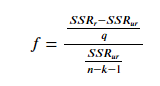

## The race, the information about condos and the level of education are statistically significant

In [33]:
ur_model = result3
r_model = result0
SSR_ur = sum(ur_model.resid**2)
SSR_r = sum(r_model.resid**2)
k = 8 # Number of variables in the ur_model
q = 3 # Restrictions
n = len(df)
f_stat = ((SSR_r-SSR_ur)/q)/(SSR_ur/(n-k-1))
p_val = f.sf(f_stat,q,n-k-1)
print("f_stat is %f" % f_stat)
print("p value is %f" % p_val)

f_stat is 22.704728
p value is 0.000000


## Factors making the monetary rewards of appealing. Money one might gain from a successful appeal

In [34]:
df[["appeal", "value", "av1", "taxes", "medhinc"]]

,appeal,value,av1,taxes,medhinc
0,0.0,108000,11558.0,1585.20000,30065.0
1,0.0,215000,19357.0,3032.43990,87268.0
2,4199.0,1364225,76189.0,11644.69000,32930.0
3,39109.0,1091500,61525.0,3215.55000,92589.0
4,0.0,380000,44434.0,7200.37990,31063.0
5,0.0,379000,42633.0,3999.46000,55300.0
6,0.0,700000,60341.0,10827.98000,71563.0
7,9793.0,905000,83075.0,8770.46000,85528.0
8,27671.0,656250,84301.0,10377.20000,62623.0
9,3080.0,355000,39731.0,6576.87990,51393.0


In [35]:
df["appeal"].describe()

count      6353.000000
mean       5487.903982
std       15608.227174
min           0.000000
25%           0.000000
50%        1175.000000
75%        4543.000000
max      419346.000000
Name: appeal, dtype: float64

In [36]:
df_appeal = df.dropna(axis=0, subset=["appeal"])
df_appeal = df_appeal[(df_appeal["appeal"]>5200)]
df_appeal = pd.get_dummies(df_appeal, columns=["tri"])

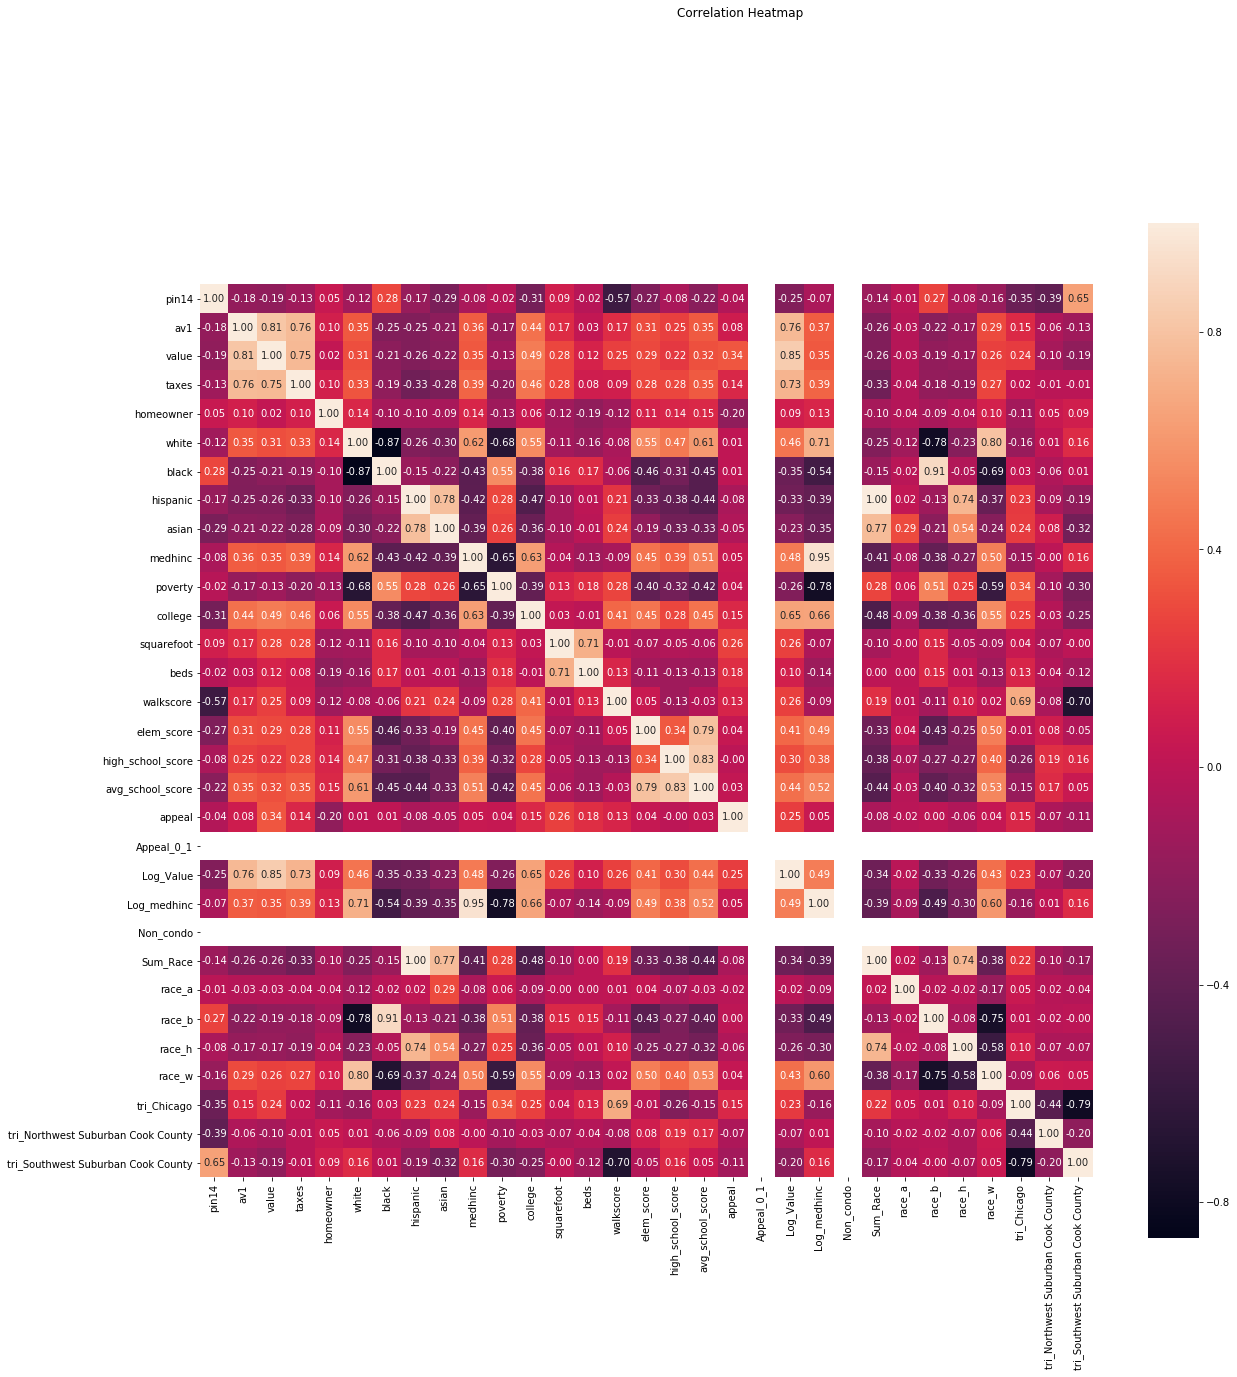

In [37]:
import matplotlib.pyplot as plt
corrmat = df_appeal.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(round(corrmat,22), annot=True, ax=ax, square=True, fmt='.2f')
fig.subplots_adjust(top=0.83)
t=fig.suptitle("Correlation Heatmap", fontsize=12)

In [38]:
# Ignoring the non numerical columns
less_cols = ["av1", "tri_Chicago", "value", "taxes", "tri_Northwest Suburban Cook County", "medhinc", "squarefoot", "college", "walkscore", "elem_score", "beds", "avg_school_score"]
for col in less_cols:
    corr, _ = pearsonr(df_appeal[col], df_appeal["appeal"])
    print("Pearson Correlation: %s %.3f" % (col, corr))

Pearson Correlation: av1 0.078
Pearson Correlation: tri_Chicago 0.147
Pearson Correlation: value 0.339
Pearson Correlation: taxes 0.140
Pearson Correlation: tri_Northwest Suburban Cook County -0.071
Pearson Correlation: medhinc 0.048
Pearson Correlation: squarefoot 0.263
Pearson Correlation: college 0.153
Pearson Correlation: walkscore 0.129
Pearson Correlation: elem_score 0.044
Pearson Correlation: beds 0.177
Pearson Correlation: avg_school_score 0.027


In [39]:
df_appeal.columns
df_appeal[["av1", "tri_Chicago", "value", "taxes", "tri_Northwest Suburban Cook County", "medhinc", "squarefoot", "Non_condo", "college", "walkscore", "elem_score", "avg_school_score","appeal"]]

Index(['pin14', 'pdir', 'pstreet', 'pcity', 'tcity', 'av1', 'value', 'taxes',
       'homeowner', 'white', 'black', 'hispanic', 'asian', 'medhinc',
       'poverty', 'college', 'squarefoot', 'beds', 'walkscore', 'walkfac',
       'elem_score', 'high_school_score', 'avg_school_score', 'appeal',
       'Appeal_0_1', 'Log_Value', 'Log_medhinc', 'Non_condo', 'Sum_Race',
       'race_a', 'race_b', 'race_h', 'race_w', 'tri_Chicago',
       'tri_Northwest Suburban Cook County',
       'tri_Southwest Suburban Cook County'],
      dtype='object')

,av1,tri_Chicago,value,taxes,tri_Northwest Suburban Cook County,medhinc,squarefoot,Non_condo,college,walkscore,elem_score,avg_school_score,appeal
3,61525.0,1,1091500,3215.55000,0,92589.0,2620.0,1,0.517047,76,8,9,39109.0
7,83075.0,1,905000,8770.46000,0,85528.0,1438.0,1,0.696402,94,7,8,9793.0
8,84301.0,1,656250,10377.20000,0,62623.0,4950.0,1,0.462252,93,5,6,27671.0
10,66777.0,1,760000,10183.14000,0,89420.0,2670.0,1,0.631579,90,9,7,8583.0
14,49414.0,1,438000,6903.54980,0,40000.0,3390.0,1,0.164449,80,5,6,6989.0
15,-19606.0,1,318660,3182.17990,0,89183.0,3199.0,1,0.432736,87,2,3,42012.0
18,23049.0,1,175000,2305.62990,0,28750.0,3261.0,1,0.059401,69,2,2,6470.0
19,-53022.0,1,520000,7497.23000,0,109167.0,2156.0,1,0.607022,89,6,8,92632.0
23,25344.0,1,360000,913.53003,0,33750.0,2184.0,1,0.192677,64,4,5,7633.0
27,49184.0,1,505000,5811.73000,0,101402.0,2221.0,1,0.427907,50,9,8,8620.0


In [40]:
model0 = sm.ols("appeal ~ av1 + tri_Chicago + value + taxes + squarefoot + medhinc + beds", data = df_appeal)
result0 = model0.fit()
model1 = sm.ols("appeal ~ av1 + tri_Chicago + value + taxes + squarefoot + college + medhinc + beds", data = df_appeal)
result1 = model1.fit()
model2 = sm.ols("appeal ~ av1 + tri_Chicago + value + taxes + squarefoot + college + Non_condo + medhinc + beds", data = df_appeal)
result2 = model2.fit()
model3 = sm.ols("appeal ~ av1 + tri_Chicago + value + taxes + squarefoot + college + Non_condo + avg_school_score + medhinc + beds", data = df_appeal)
result3 = model3.fit()
model4 = sm.ols("appeal ~ av1 + tri_Chicago + value + taxes + squarefoot + college + Non_condo + avg_school_score + poverty + medhinc + beds", data = df_appeal)
result4 = model4.fit()

# Using a multivariate model
print ("R Squared for Model0 is %f" % result0.rsquared)
print ("R Squared for Model1 is %f" % result1.rsquared)
print ("R Squared for Model2 is %f" % result2.rsquared)
print ("R Squared for Model3 is %f" % result3.rsquared)
print ("R Squared for Model4 is %f" % result4.rsquared)
result4.summary()




R Squared for Model0 is 0.254290
R Squared for Model1 is 0.256071
R Squared for Model2 is 0.256071
R Squared for Model3 is 0.256095
R Squared for Model4 is 0.256386


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 appeal   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     49.58
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           1.56e-85
Time:                        06:48:15   Log-Likelihood:                -16665.
No. Observations:                1449   AIC:                         3.335e+04
Df Residuals:                    1438   BIC:                         3.341e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2286.4635   1853.853      1.233      0.218   -1350.083    5923.010
av1                 -0.2498      0.022    -11.464      0.000      -0.293      -0.207
tri_Chicago        852.2669   1687.390      0.505      0.614   -2457.742    4162.276
value                0.0358      0.002     16.980      0.000       0.032       0.040
taxes               -0.5107      0.169     -3.031      0.002      -0.841      -0.180
squarefoot           3.3128      0.617      5.368      0.000       2.102       4.523
college           1.028e+04   5303.623      1.938      0.053    -126.913    2.07e+04
Non_condo         2286.4635   1853.853      1.233      0.218   -1350.083    5923.010
avg_school_score   -60.6557    377.815     -0.161      0.872    -801.783     680.472
poverty           6630.6824   8839.631      0.750      0.453   -1.07e+04     2.4e+04
medhinc             -0.0054      0.032     -0.167      0.867      -0.069       0.058
beds              -352.5239    397.266     -0.887      0.375   -1131.808     426.760
==============================================================================
Omnibus:                     1360.614   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            88443.215
Skew:                           4.195   Prob(JB):                         0.00
Kurtosis:                      40.343   Cond. No.                     5.49e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.61e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Hypothesis testing
Let's compute the sum of the squared residuals in the restricted model named Model0, and the unrestricted model named Model3, divide by number of restrictions. We will divide by the quared residuals in the unrestricted model named Model0, divided by the degrees of freedom.
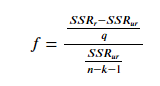

In [41]:
ur_model = result4
r_model = result0
SSR_ur = sum(ur_model.resid**2)
SSR_r = sum(r_model.resid**2)
k = 10 # Number of variables in the ur_model
q = 6 # Restrictions
n = len(df_appeal)
f_stat = ((SSR_r-SSR_ur)/q)/(SSR_ur/(n-k-1))
p_val = f.sf(f_stat,q,n-k-1)
print("f_stat is %f" % f_stat)
print("p value is %f" % p_val)

f_stat is 0.675487
p value is 0.669525


# Conclusion

We applied various method to make inference about what are the factors that lead a property owner to appeal and what factors affect the monetary rewards of appealing, what influences how much money one might gain from a successful appeal<br>
From correlation heatmap graph we can see Appeal_0_1 is correlated with following valables: college, av1>taxes>Log_Value>squarefoot>medhinc>avg_school_score>race_w(White), and even the race_a(Asian) is positive correlated with Appeal_0_1 but it's too small can be dropped and the other two races are negative correlated<br>
We created multivariate models and with OLS Regression Results we find the most significant factors that lead to appeal happen or not; also we use Hypothesis testing<br>
Also I would like to collect the time value, in that case we can use DID method to find out for certain location before / after appeal will inpact the accuracy rate for the assessed value from CCAO or not<br>